# **Derin Öğrenme ile Tıbbi Görüntü Analizi - I**
## **Tıbbi Görüntü Veri Formatı .dcm**
Tıbbi görüntüler, tıbbi görüntü verilerini depolamak ve değiştirmek için standart bir çözüm olarak Dijital Görüntüleme ve İletişimi (DICOM) takip eder . Bu standardın ilk versiyonu 1985 yılında yayınlanmıştır. O zamandan beri yapılan birkaç değişiklik var. Bu standart bir dosya formatı ve bir iletişim protokolü kullanır.

* Dosya Biçimi  - Tüm tıbbi görüntüler DICOM dosya biçiminde kaydedilir. Bu format, görüntüyü yakalamak için kullanılan ekipman ve tıbbi tedavi ile ilgili bazı bağlamlar gibi diğer görüntüye ek verilerle birlikte isim, cinsiyet, yaş gibi hasta hakkında PHI'ya (korunmuş sağlık bilgisi) sahiptir . Tıbbi Görüntüleme Ekipmanı, DICOM dosyaları oluşturur. Doktorlar, DICOM görüntülerini görüntüleyebilen bilgisayar yazılımı uygulamaları olan DICOM Görüntüleyicilerini kullanır, görüntülerde bulunan bulguları okur ve teşhis eder.
* İletişim Protokolü  - DICOM iletişim protokolü, arşivdeki görüntüleme çalışmalarını aramak ve görüntülemek için görüntüleme çalışmalarını iş istasyonuna geri yüklemek için kullanılır. Hastane ağına bağlı olan tüm tıbbi görüntüleme uygulamaları, bilgi alışverişinde, özellikle de DICOM görüntülerinde, ayrıca hasta ve prosedür bilgilerinde DICOM protokolünü kullanır. Tedaviyi kontrol etmek ve takip etmek, prosedürleri zamanlamak, durumları rapor etmek ve iş yükünü doktorlar ve görüntüleme cihazları arasında paylaşmak için kullanılan daha gelişmiş ağ komutları da vardır.

# Gerekli Kütüphaneler

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pydicom as pdicom #pip install pydicom
import os
import glob
%matplotlib inline

In [5]:
import pandas as pd
import scipy.ndimage
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# .dcm uzantılı görüntülerin bulunduğu klasöre erişme
### örnek görüntüler https://mri.radiology.uiowa.edu/visible_human_datasets.html sayfasından alınmıştır

In [61]:
INPUT_FOLDER='Hip/'
patients=os.listdir(INPUT_FOLDER)
patients.sort()

# İlgili klasördeki resimleri lstFilesDCM listesine ekleyelim

In [62]:
lstFilesDCM=[]
def load_scan2(path):
    for dirName, subdirList, fileList in os.walk(path):
        for filename in fileList:
            if ".dcm" in filename.lower():
                lstFilesDCM.append(os.path.join(dirName,filename))
    return lstFilesDCM
first_patient=load_scan2(INPUT_FOLDER)

# Herhangi bir resmi alma ve boyutlarına erişme

In [63]:
# kaç görüntü var
len(lstFilesDCM)

400

In [64]:
RefDs=pdicom.read_file(lstFilesDCM[350])
ConstPixelDims=(int(RefDs.Rows),int(RefDs.Columns),len(lstFilesDCM))
ConstPixelSpacing=(float(RefDs.PixelSpacing[0]),float(RefDs.PixelSpacing[1]),
                  float(RefDs.SliceThickness))

In [65]:
x=np.arange(0.0,(ConstPixelDims[0]+1)*ConstPixelSpacing[0],ConstPixelSpacing[0])
y=np.arange(0.0,(ConstPixelDims[1]+1)*ConstPixelSpacing[1],ConstPixelSpacing[1])
z=np.arange(0.0,(ConstPixelDims[2]+1)*ConstPixelSpacing[2],ConstPixelSpacing[2])

### Daha sonra, x, y ve z kartezyen eksenleri boyunca (Bir dilimdeki piksel satır sayısı) x (bir dilimdeki piksel sütun sayısı) x (dilimdeki piksel sayısı) değerine eşit olan 3B NumPy dizisinin toplam boyutlarını hesaplarız. . Son olarak, üç eksendeki pikseller arasındaki boşluğu hesaplamak için *PixelSpacing* ve *SliceThickness*niteliklerini kullanıyoruz . Dizi boyutlarını *ConstPixelDims* ve *ConstPixelSpacing* boşlukları saklıyoruz.

In [66]:
ArrayDicom=np.zeros(ConstPixelDims,dtype=RefDs.pixel_array.dtype)

for filenameDCM in lstFilesDCM:
    ds=pdicom.read_file(filenameDCM)
    ArrayDicom[:,:,lstFilesDCM.index(filenameDCM)]=ds.pixel_array

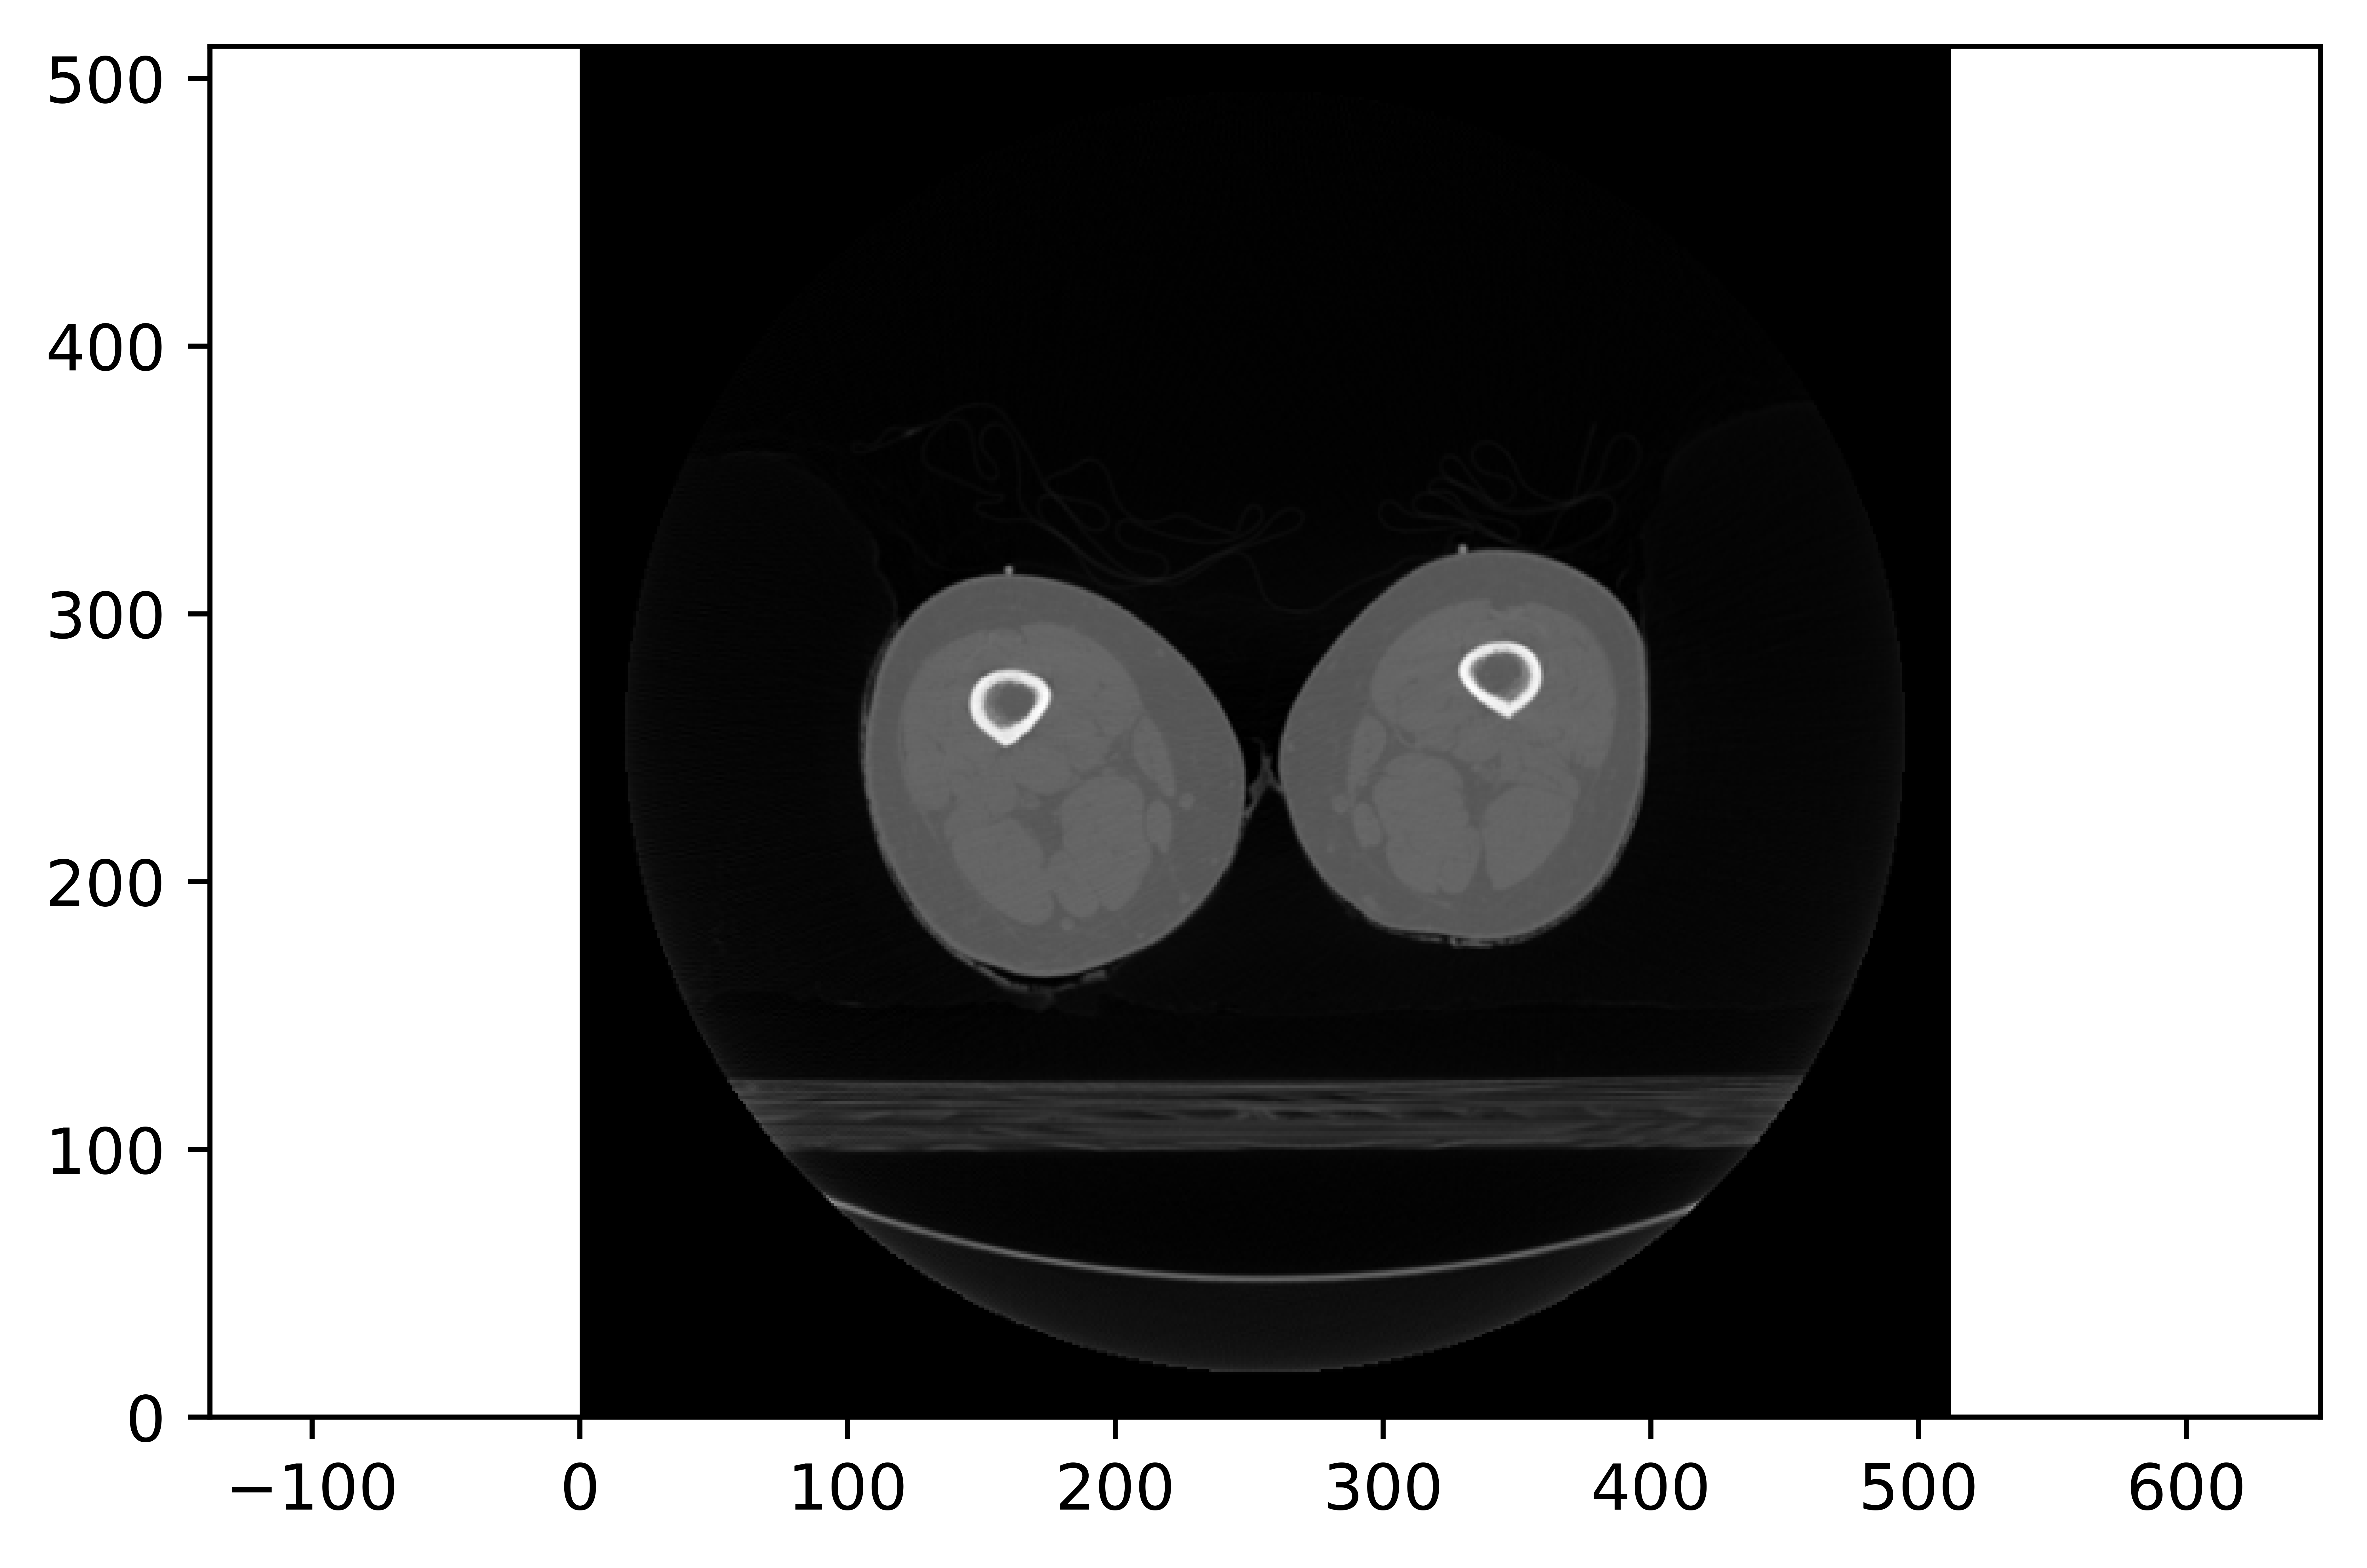

In [67]:
plt.figure(dpi=1600)
plt.axes().set_aspect('equal','datalim')
plt.set_cmap(plt.gray())
plt.pcolormesh(x,y,np.flipud(ArrayDicom[:,:,120]))

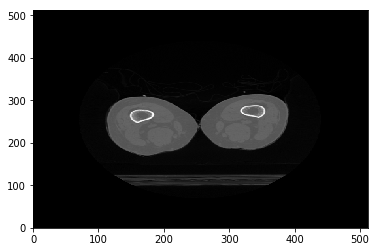

In [68]:
plt.pcolormesh(x,y,np.flipud(ArrayDicom[:,:,80]))

# **DICOM formatının ayrıntılarına bakma**

BT taramalarındaki ölçüm birimi , radyo yoğunluğunun bir ölçüsü olan Hounsfield Ünitesidir (HU) . CT tarayıcıları bunu doğru bir şekilde ölçmek için dikkatlice kalibre edilir.

Her piksele karşılık gelen vokselde bulunan tüm zayıflama değerlerinin ortalaması olan sayısal bir değer (CT numarası) atanır. Bu sayı suyun zayıflama değeriyle karşılaştırılır ve Sir Godfrey Hounsfield'dan sonra Hounsfield ünitesi (HU) adında isteğe bağlı birimler ölçeğinde gösterilir.

Bu ölçek, suyu sıfır bir zayıflama değeri (HU) olarak atar. Bazı modern tarayıcılar 4000'e kadar daha yüksek HU aralığına sahip olmasına rağmen , CT sayıları 2000 HU'dur . Her sayı, spektrumun her iki ucunda +1000 (beyaz) ve –1000 (siyah) içeren gri bir gölgeyi temsil eder.

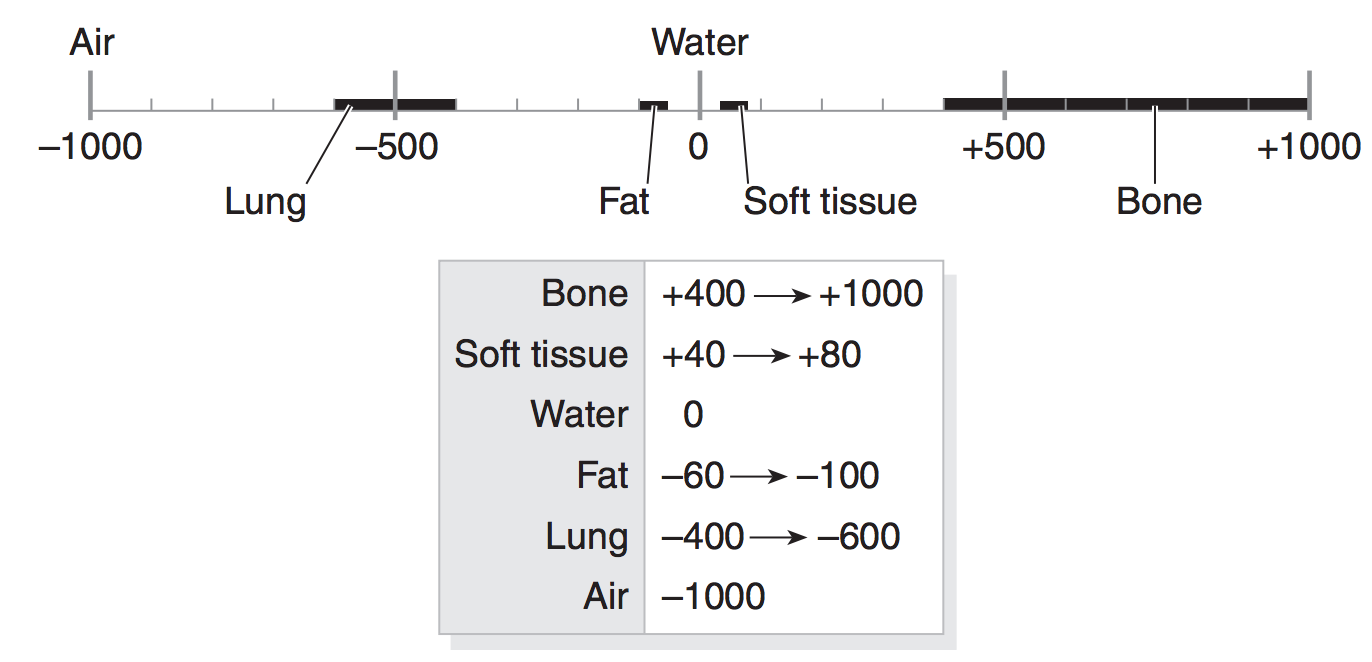

In [59]:
from IPython.display import Image
Image(filename='a.png') 

Bazı tarayıcılar silindirik tarama sınırlarına sahiptir, ancak çıktı görüntüsü karedir. Bu sınırların dışına düşen pikseller **-2000** sabit değerini alır .

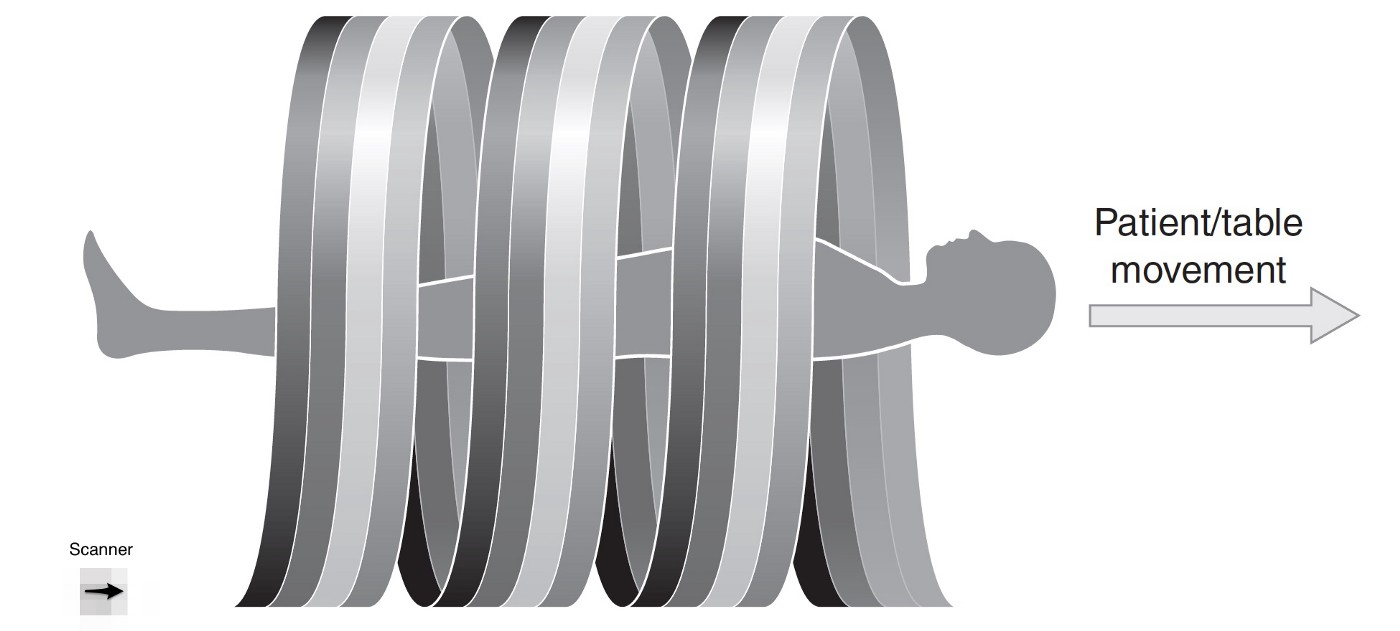

In [60]:
Image(filename='b.jpeg') 

İlk adım genellikle bu değerleri 0'a ayarlamaktır. Daha sonra, yeniden ölçekleme eğimi ile çarparak ve kesişme (taramaların meta verilerinde uygun şekilde saklanan!) Ekleyerek HU ünitelerine geri dönelim.

**Bir sonraki bölümde, Keras kullanarak Kaggle'ın akciğer kanseri veri setini ve Konvolüsyon Sinir Ağlarına bakacağız.**